# Simple Inference

In [58]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

/Users/j.seporaitis/.virtualenvs/hsaur/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [59]:
sns.set(color_codes=True)

## Estimating the Width of a Room

In [80]:
roomwidth = pd.read_csv('roomwidth.csv')
del roomwidth['Unnamed: 0']
roomwidth.head()

,unit,width
0,metres,8
1,metres,9
2,metres,10
3,metres,10
4,metres,10


In [61]:
def convert(row):
    if row['unit'] == 'metres':
        row['width'] *= 3.28
    return row

roomwidth = roomwidth.apply(convert, axis=1)

In [62]:
roomwidth[roomwidth['unit'] == 'metres'].describe()

,width
count,44.000000
mean,52.554545
std,23.434443
min,26.240000
25%,36.080000
50%,49.200000
75%,55.760000
max,131.200000


In [63]:
roomwidth[roomwidth['unit'] == 'feet'].describe()

,width
count,69.000000
mean,43.695652
std,12.497417
min,24.000000
25%,36.000000
50%,42.000000
75%,48.000000
max,94.000000


In [64]:
print(
    round(roomwidth[roomwidth['unit'] == 'feet']['width'].std(), 1), 
    round(roomwidth[roomwidth['unit'] == 'metres']['width'].std(), 1),
)

12.5 23.4


/Users/j.seporaitis/.virtualenvs/hsaur/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


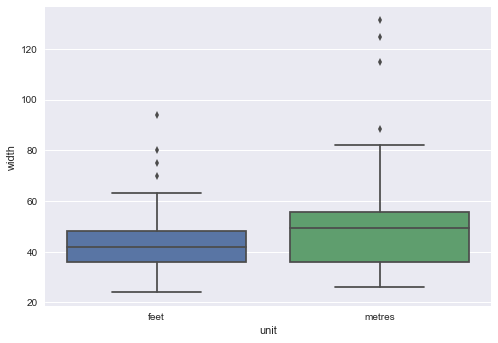

In [65]:
sns.boxplot(x="unit", y="width", data=roomwidth, order=['feet', 'metres'])

_The boxplots indicate that both sets of estimates contain a number of outliers and also that the estimates made in meters are skewed and more variable than those made in feet, a point underlined by the numerical summary statistics above. Both normal probability plots depart from linearity, suggesting that the distributions of both sets of estimates are not normal. The presence of outliers, the apparently different variances and the evidence of non-normality all suggest caution in applying the t-test, but for the moment we shall apply the usual version of the test._

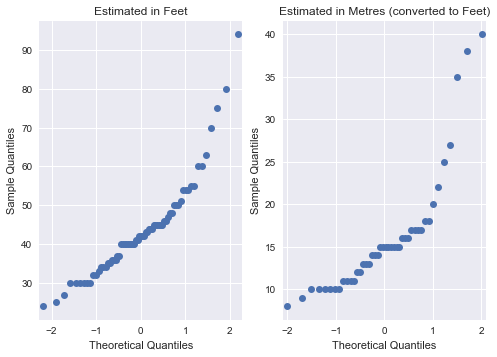

In [89]:
fig, ax = plt.subplots(ncols=2)
sm.qqplot(roomwidth[roomwidth['unit'] == 'feet']['width'], ax=ax[0])
ax[0].set_title("Estimated in Feet")
sm.qqplot(roomwidth[roomwidth['unit'] == 'metres']['width'], ax=ax[1])
ax[1].set_title("Estimated in Metres (converted to Feet)")
plt.show()

In [92]:
print("Student t-test")
stats.ttest_ind(
    a=roomwidth[roomwidth['unit'] == 'feet']['width'],
    b=roomwidth[roomwidth['unit'] == 'metres']['width'],
)

Student t-test


Ttest_indResult(statistic=13.349315016176329, pvalue=7.936895027700526e-25)

In [93]:
print("Welch t-test")
stats.ttest_ind(
    a=roomwidth[roomwidth['unit'] == 'feet']['width'],
    b=roomwidth[roomwidth['unit'] == 'metres']['width'],
    equal_var=False,
)

Welch t-test


Ttest_indResult(statistic=14.955731803687149, pvalue=2.936884786397076e-28)